In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
!pip install tensorboardX

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [ ]:
import matplotlib.pyplot as plt

plt.style.use(['dark_background'])
%matplotlib inline

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

In [ ]:
import matplotlib.pyplot as plt
def plot(steps_done, episode, t, total_rewards,total_reward):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('total_reward')
    plt.plot(total_rewards)

    plt.pause(0.001)
    print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'\
          .format(steps_done, episode, t, total_reward))  
    if is_ipython: display.clear_output(wait=True)

In [ ]:
# import os
# os.getcwd()
# os.chdir(r'/content/drive/MyDrive/ANN_fall99/HW2/dataset')

In [ ]:
import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time
import pickle

import gym

from wrappers import *
from memory import ReplayMemory
from models import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

Transition = namedtuple('Transion', 
                        ('state', 'action', 'next_state', 'reward'))

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END)* \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.to('cuda')).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)

def get_state(obs):
    state = np.array(obs)
    state = state.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    return state.unsqueeze(0)



# DQN:

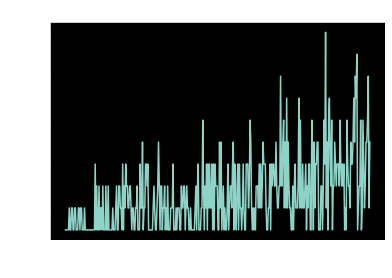

Total steps: 485369 	 Episode: 399/1491 	 Total reward: -17.0


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    """
    zip(*transitions) unzips the transitions into
    Transition(*) creates new named tuple
    batch.state - tuple of all the states (each state is a tensor)
    batch.next_state - tuple of all the next states (each state is a tensor)
    batch.reward - tuple of all the rewards (each reward is a float)
    batch.action - tuple of all the actions (each action is an int)    
    """
    batch = Transition(*zip(*transitions))
    
    actions = tuple((map(lambda a: torch.tensor([[a]], device='cuda'), batch.action))) 
    rewards = tuple((map(lambda r: torch.tensor([r], device='cuda'), batch.reward))) 

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.uint8)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None]).to('cuda')
    

    state_batch = torch.cat(batch.state).to('cuda')
    action_batch = torch.cat(actions)
    reward_batch = torch.cat(rewards)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def train(env, n_episodes, render=False):
    total_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)

            if render:
                env.render()

            obs, reward, done, info = env.step(action)

            total_reward += reward

            if not done:
                next_state = get_state(obs)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
            state = next_state

            if steps_done > INITIAL_MEMORY:
                optimize_model()

                if steps_done % TARGET_UPDATE == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            if done:
                break
        total_rewards.append(total_reward)
        # if episode % 20 == 0:
        plot(steps_done, episode, t, total_rewards,total_reward)      
        # print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'.format(steps_done, episode, t, total_reward))
    env.close()
    return

if __name__ == '__main__':
    # set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # hyperparameters
    BATCH_SIZE = 32
    GAMMA = 0.99
    EPS_START = 1
    EPS_END = 0.02
    EPS_DECAY = 1000000
    TARGET_UPDATE = 1000
    RENDER = False
    lr = 1e-4
    INITIAL_MEMORY = 10000
    MEMORY_SIZE = 10 * INITIAL_MEMORY

    # create networks
    policy_net = DQN(n_actions=4).to(device)
    target_net = DQN(n_actions=4).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    # setup optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    steps_done = 0

    # create environment
    env = gym.make("PongNoFrameskip-v4")
    env = make_env(env)

    # initialize replay memory
    memory = ReplayMemory(MEMORY_SIZE)
    
    # train model
    train(env, 400)
    # torch.save(policy_net, "dqn_pong_model")
    # policy_net = torch.load("dqn_pong_model")
    # test(env, 1, policy_net, render=False)

In [ ]:
total_rewards

# DDQN:

In [ ]:
t1 = time.time()
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    """
    zip(*transitions) unzips the transitions into
    Transition(*) creates new named tuple
    batch.state - tuple of all the states (each state is a tensor)
    batch.next_state - tuple of all the next states (each state is a tensor)
    batch.reward - tuple of all the rewards (each reward is a float)
    batch.action - tuple of all the actions (each action is an int)    
    """
    batch = Transition(*zip(*transitions))
    
    actions = tuple((map(lambda a: torch.tensor([[a]], device='cuda'), batch.action))) 
    rewards = tuple((map(lambda r: torch.tensor([r], device='cuda'), batch.reward))) 

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.uint8)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None]).to('cuda')
    

    state_batch = torch.cat(batch.state).to('cuda')
    action_batch = torch.cat(actions)
    reward_batch = torch.cat(rewards)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    ###
    ###
    am = policy_net(non_final_next_states).max(dim=1)[1] #argmaxes!
    qs = target_net(non_final_next_states)
    next_state_values[non_final_mask] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
    ###
    ###
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def train(env, n_episodes, render=False):
    total_rewards = []
    for episode in range(n_episodes):
        if steps_done % TARGET_UPDATE == 0:
          target_net.load_state_dict(policy_net.state_dict())
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)

            if render:
                env.render()

            obs, reward, done, info = env.step(action)

            total_reward += reward

            if not done:
                next_state = get_state(obs)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
            state = next_state

            if episode > INITIAL_MEMORY:
                optimize_model()

              # if steps_done % TARGET_UPDATE == 0:
              #     target_net.load_state_dict(policy_net.state_dict())

            if done:
                break
        total_rewards.append(total_reward)
        # if episode % 20 == 0:
        plot(steps_done, episode, t, total_rewards,total_reward)      
        # print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'.format(steps_done, episode, t, total_reward))
    env.close()
    return

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    BATCH_SIZE = 256
    GAMMA = 0.99
    EPS_START = 1
    EPS_END = 0.01
    EPS_DECAY = 1000000
    TARGET_UPDATE = 10
    RENDER = False
    lr = 1e-3
    INITIAL_MEMORY = 10000
    MEMORY_SIZE = 50 * INITIAL_MEMORY

    policy_net = DQN(n_actions=4).to(device)
    target_net = DQN(n_actions=4).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    steps_done = 0

    env = gym.make("PongNoFrameskip-v4")
    env = make_env(env)

    memory = ReplayMemory(MEMORY_SIZE)
    
    train(env, 300)
    t2 = time.time()
    et_ddqn = t2-t1

In [ ]:
print(et_ddqn)

# TDQN:

In [ ]:
  def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))
    
    actions = tuple((map(lambda a: torch.tensor([[a]], device='cuda'), batch.action))) 
    rewards = tuple((map(lambda r: torch.tensor([r], device='cuda'), batch.reward))) 

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.uint8)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None]).to('cuda')
    

    state_batch = torch.cat(batch.state).to('cuda')
    action_batch = torch.cat(actions)
    reward_batch = torch.cat(rewards)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    ###
    ###
    am = target_net2(non_final_next_states).max(dim=1)[1] #argmaxes!
    qs = target_net(non_final_next_states)
    next_state_values[non_final_mask] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
    ###
    ###
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def train(env, n_episodes, render=False):
    total_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)

            if render:
                env.render()

            obs, reward, done, info = env.step(action)

            total_reward += reward

            if not done:
                next_state = get_state(obs)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
            state = next_state

            if steps_done > INITIAL_MEMORY:
                optimize_model()

                if steps_done % TARGET_UPDATE == 0:
                    target_net.load_state_dict(policy_net.state_dict())

                if steps_done % TARGET_UPDATE2 == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            if done:
                break
        total_rewards.append(total_reward)
        # if episode % 20 == 0:
        plot(steps_done, episode, t, total_rewards,total_reward)      
        # print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'.format(steps_done, episode, t, total_reward))
    env.close()
    return

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    BATCH_SIZE = 32
    GAMMA = 0.99
    EPS_START = 1
    EPS_END = 0.02
    EPS_DECAY = 1000000
    TARGET_UPDATE = 1000
    TARGET_UPDATE2 = 500
    RENDER = False
    lr = 1e-4
    INITIAL_MEMORY = 10000
    MEMORY_SIZE = 10 * INITIAL_MEMORY

    policy_net = DQN(n_actions=4).to(device)

    target_net = DQN(n_actions=4).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    target_net2 = DQN(n_actions=4).to(device)
    target_net2.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    steps_done = 0

    env = gym.make("PongNoFrameskip-v4")
    env = make_env(env)

    memory = ReplayMemory(MEMORY_SIZE)
    
    train(env, 100)

# SDDQN:

In [ ]:
  def optimize_model(policy,target1,target2,optimizer_):
      if len(memory) < BATCH_SIZE:
          return
      transitions = memory.sample(BATCH_SIZE)

      batch = Transition(*zip(*transitions))
      
      actions = tuple((map(lambda a: torch.tensor([[a]], device='cuda'), batch.action))) 
      rewards = tuple((map(lambda r: torch.tensor([r], device='cuda'), batch.reward))) 

      non_final_mask = torch.tensor(
          tuple(map(lambda s: s is not None, batch.next_state)),
          device=device, dtype=torch.uint8)
      
      non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None]).to('cuda')
      

      state_batch = torch.cat(batch.state).to('cuda')
      action_batch = torch.cat(actions)
      reward_batch = torch.cat(rewards)
      
      state_action_values = policy(state_batch).gather(1, action_batch)
      
      next_state_values = torch.zeros(BATCH_SIZE, device=device)
      ###
      ###
      am = target2(non_final_next_states).max(dim=1)[1] #argmaxes!
      qs = target1(non_final_next_states)
      next_state_values[non_final_mask] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
      ###
      ###
      expected_state_action_values = (next_state_values * GAMMA) + reward_batch
      
      loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
      
      optimizer_.zero_grad()
      loss.backward()
      for param in policy.parameters():
          param.grad.data.clamp_(-1, 1)
      optimizer_.step()

def train(env, n_episodes, render=False):
    total_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)

            if render:
                env.render()

            obs, reward, done, info = env.step(action)

            total_reward += reward

            if not done:
                next_state = get_state(obs)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
            state = next_state

            if steps_done > INITIAL_MEMORY:
                optimize_model(policy_net,targe_net,target_net2,optimizer1)
                optimize_model(policy_net2,targe_net2,target_net,optimizer2)

                if steps_done % TARGET_UPDATE == 0:
                    target_net.load_state_dict(policy_net.state_dict())

                if steps_done % TARGET_UPDATE2 == 0:
                    target_net2.load_state_dict(policy_net2.state_dict())

            if done:
                break
        total_rewards.append(total_reward)
        # if episode % 20 == 0:
        plot(steps_done, episode, t, total_rewards,total_reward)      
        # print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'.format(steps_done, episode, t, total_reward))
    env.close()
    return

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    BATCH_SIZE = 32
    GAMMA = 0.99
    EPS_START = 1
    EPS_END = 0.02
    EPS_DECAY = 1000000
    TARGET_UPDATE = 1000
    TARGET_UPDATE2 = 1000
    RENDER = False
    lr = 1e-4
    INITIAL_MEMORY = 10000
    MEMORY_SIZE = 10 * INITIAL_MEMORY

    policy_net = DQN(n_actions=4).to(device)
    policy_net2 = DQN(n_actions=4).to(device)

    target_net = DQN(n_actions=4).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    target_net2 = DQN(n_actions=4).to(device)
    target_net2.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    optimizer2 = optim.Adam(policy_net2.parameters(), lr=lr)

    steps_done = 0

    env = gym.make("PongNoFrameskip-v4")
    env = make_env(env)

    memory = ReplayMemory(MEMORY_SIZE)
    
    train(env, 100)

# FDDQN:

In [ ]:
  def optimize_model(policy,target1,target2,optimizer_):
      if len(memory) < BATCH_SIZE:
          return
      transitions = memory.sample(BATCH_SIZE)

      batch = Transition(*zip(*transitions))
      
      actions = tuple((map(lambda a: torch.tensor([[a]], device='cuda'), batch.action))) 
      rewards = tuple((map(lambda r: torch.tensor([r], device='cuda'), batch.reward))) 

      non_final_mask = torch.tensor(
          tuple(map(lambda s: s is not None, batch.next_state)),
          device=device, dtype=torch.uint8)
      
      non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None]).to('cuda')
      

      state_batch = torch.cat(batch.state).to('cuda')
      action_batch = torch.cat(actions)
      reward_batch = torch.cat(rewards)
      
      state_action_values = policy(state_batch).gather(1, action_batch)
      
      next_state_values = torch.zeros(BATCH_SIZE, device=device)
      ###
      ###
      am = target2(non_final_next_states).max(dim=1)[1] #argmaxes!
      qs = target1(non_final_next_states)
      next_state_values[non_final_mask] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
      ###
      ###
      expected_state_action_values = (next_state_values * GAMMA) + reward_batch
      
      loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
      
      optimizer_.zero_grad()
      loss.backward()
      for param in policy.parameters():
          param.grad.data.clamp_(-1, 1)
      optimizer_.step()

def train(env, n_episodes, render=False):
    total_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)

            if render:
                env.render()

            obs, reward, done, info = env.step(action)

            total_reward += reward

            if not done:
                next_state = get_state(obs)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
            state = next_state

            if steps_done > INITIAL_MEMORY:
                optimize_model(policy_net,targe_net,target_net2,optimizer1)
                optimize_model(policy_net2,targe_net2,target_net,optimizer2)

                if steps_done % TARGET_UPDATE == 0:
                    target_net.load_state_dict(policy_net.state_dict())

                if steps_done % TARGET_UPDATE2 == 0:
                    target_net2.load_state_dict(policy_net2.state_dict())

            if done:
                break
        total_rewards.append(total_reward)
        # if episode % 20 == 0:
        plot(steps_done, episode, t, total_rewards,total_reward)      
        # print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'.format(steps_done, episode, t, total_reward))
    env.close()
    return

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    BATCH_SIZE = 32
    GAMMA = 0.99
    EPS_START = 1
    EPS_END = 0.02
    EPS_DECAY = 1000000
    TARGET_UPDATE = 1000
    TARGET_UPDATE2 = 1000
    RENDER = False
    lr = 1e-4
    INITIAL_MEMORY = 10000
    MEMORY_SIZE = 10 * INITIAL_MEMORY

    policy_net = DQN(n_actions=4).to(device)
    policy_net2 = DQN(n_actions=4).to(device)

    target_net = DQN(n_actions=4).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    target_net2 = DQN(n_actions=4).to(device)
    target_net2.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    optimizer2 = optim.Adam(policy_net2.parameters(), lr=lr)

    steps_done = 0

    env = gym.make("PongNoFrameskip-v4")
    env = make_env(env)

    memory = ReplayMemory(MEMORY_SIZE)
    
    train(env, 100)

# Complementaries:

## save notebook:

In [ ]:
# pip install dill

# import dill
# dill.dump_session('notebook_env.db')

# dill.load_session('notebook_env.db')

## save variables:

In [ ]:
# import pickle

# f = open('store.pkl', 'wb')
# pickle.dump(obj, f)
# f.close()

# f = open('store.pkl', 'rb')
# obj = pickle.load(f)
# f.close()
##############################
# import pickle

# # obj0, obj1, obj2 are created here...

# # Saving the objects:
# with open('objs.pkl', 'w') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([obj0, obj1, obj2], f)

# # Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)

### Tesnsorboard:

In [ ]:
# try:
#   %tensorflow_version 2.x
#   %load_ext tensorboard
# except:
#   pass

####################33

# %tensorboard --logdir 'logs'

## Tensorboard/Pytorch:

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# tb = SummaryWriter(log_dir = '')
# tb.add_scalar('Loss', total_loss, epoch)
# tensorboard --logdir=runs
# http://localhost:6006

## Execution Time:

In [ ]:
# import time
# t1 = time.time()
# t2 = time.time()
# print(t2-t1)